In [9]:
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import gym_anytrading

In [10]:
# Load and preprocess the data
df = pd.read_csv("../../../data/all_stocks_5yr.csv")
df.drop('Name', axis=1, inplace=True)
df.fillna(0, inplace=True)
df.set_index('Date', inplace=True)

In [11]:

# Split data into train and test sets
x_train, x_test = train_test_split(df, test_size=0.1)
del df

# Define directories for saving models and logs
models_dir = "models/A2C_B"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

| Metric                    | Description                                                                       |
|---------------------------|-----------------------------------------------------------------------------------|
| time/fps                  | Number of steps per second taken by the model during training.                    |
| iterations                | Number of iterations completed during training.                                   |
| time_elapsed              | Total time elapsed during training in seconds.                                    |
| total_timesteps           | Total number of timesteps taken by the model during training.                     |
| train/entropy_loss        | Entropy loss of the policy during training. The goal is to have enough entropy... |
| train/explained_variance  | Explained variance of the value function during training. The goal is to have ... |
| train/learning_rate       | Learning rate of the optimizer during training. It is adjusted according to th... |
| train/n_updates           | Number of updates made to the model during training.                               |
| train/policy_loss         | Policy loss of the A2C algorithm during training. The goal is to minimize it t... |
| train/value_loss          | Value function loss of the A2C algorithm during training. The goal is to minimi... |


In [12]:

# Create training environment
train_env = lambda: gym.make('stocks-v0', df=x_train, window_size=5)
env = DummyVecEnv([train_env])

# Set hyperparameters and initialize the A2C model
timesteps = 12_000
model = A2C('MlpPolicy', env=env, verbose=1, tensorboard_log=logdir)

# Train the model
for i in range(1, 30):
    model.learn(total_timesteps=timesteps, reset_num_timesteps=False, tb_log_name="A2C")
    model.save(f"{models_dir}/A2C{i * timesteps}")

Using cpu device
Logging to logs\A2C_0
------------------------------------
| time/                 |          |
|    fps                | 597      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.437   |
|    explained_variance | -892     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0855  |
|    value_loss         | 0.432    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 649      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.572   |
|    explained_variance | 0.0137   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -45.7    |

Evaluation Metrics:
                              Value
Average Reward per Step   -0.831782
Total Profit               0.289804
Accuracy of Actions        0.534945
Profit/Loss              226.346023
Sharpe Ratio               0.924755


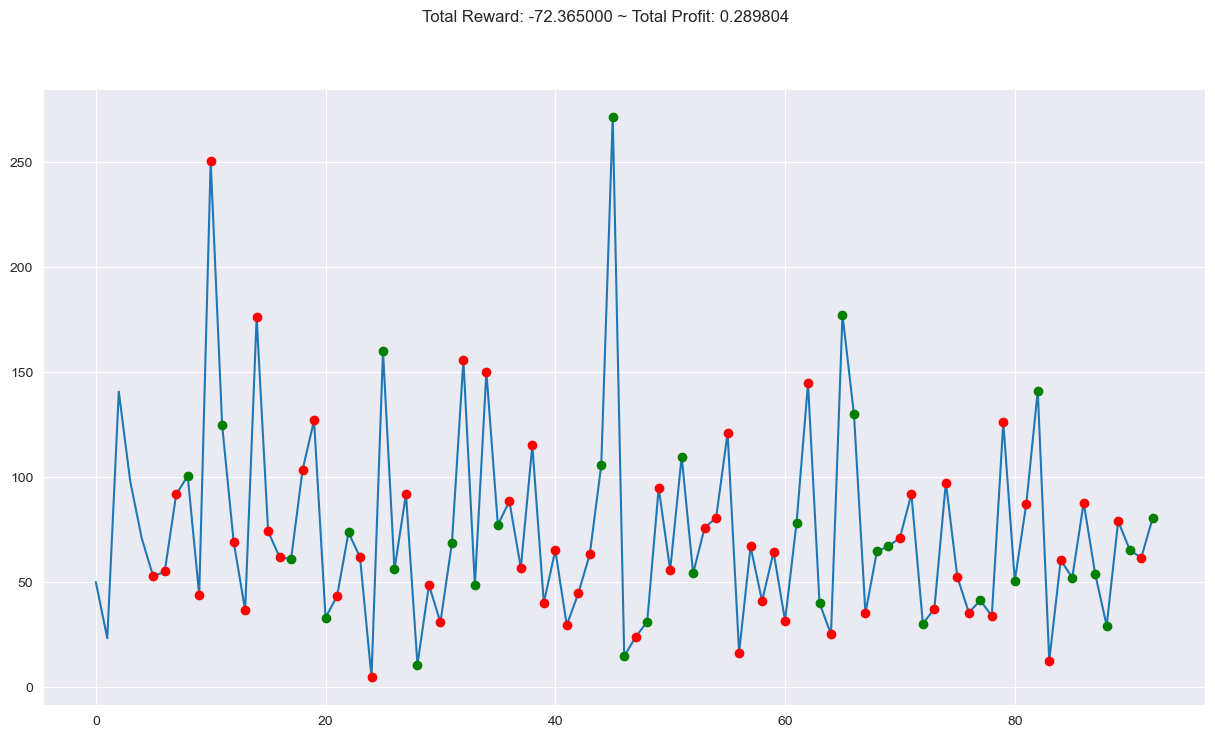

In [8]:
# Evaluation
eval_env = gym.make('stocks-v0', df=x_test, window_size=5, frame_bound=(12, 100))
obs = eval_env.reset()
rewards = []
profits = []
actions = []

while True:
    obs = obs[np.newaxis, ...]
    action, states = model.predict(obs)
    obs, reward, done, info = eval_env.step(action)

    rewards.append(reward)
    profits.append(info.get('total_profit'))
    actions.append(action)

    if done:
        evaluation_metrics = {
            'Average Reward per Step': np.mean(rewards),
            'Total Profit': info.get('total_profit'),
            'Accuracy of Actions': np.mean(np.array(actions) == np.array(eval_env.history['position'])),
            'Profit/Loss': np.sum(eval_env.history['total_profit'])
        }

        returns = np.array(eval_env.history['total_profit']) / np.sum(eval_env.history['total_profit'])
        risk_free_rate = 0.0  # Assuming no risk-free rate
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
        evaluation_metrics['Sharpe Ratio'] = sharpe_ratio

        df_metrics = pd.DataFrame.from_dict(evaluation_metrics, orient='index', columns=['Value'])
        print("Evaluation Metrics:")
        print(df_metrics)

        plt.figure(figsize=(15, 8))
        plt.cla()
        eval_env.render_all()
        plt.show()

        break


| Metric                     | Definition                               | Goal                                                       |
|----------------------------|------------------------------------------|------------------------------------------------------------|
| `time/fps`                 | Steps per second                         | Maximize                                                   |
| `train/entropy_loss`       | Entropy loss of policy                    | High enough for exploration, but not too high to prevent convergence |
| `train/explained_variance` | Explained variance of value function   | High enough to accurately estimate state values              |
| `train/learning_rate`      | Learning rate of optimizer                | Adjust according to learning schedule and convergence       |
| `train/policy_loss`        | Policy loss of A2C                        | Minimize to improve policy performance                       |
| `train/value_loss`         | Value function loss of A2C                | Minimize to improve value function accuracy                  |


In [5]:
from keras.callbacks import TensorBoard
%load_ext tensorboard
log_dir = 'logs/'  # the directory where you saved your TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=log_dir)

%tensorboard --logdir logs/  # visualize the logs in TensorBoard